In [1]:

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

## Loading the Data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# string to date format
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


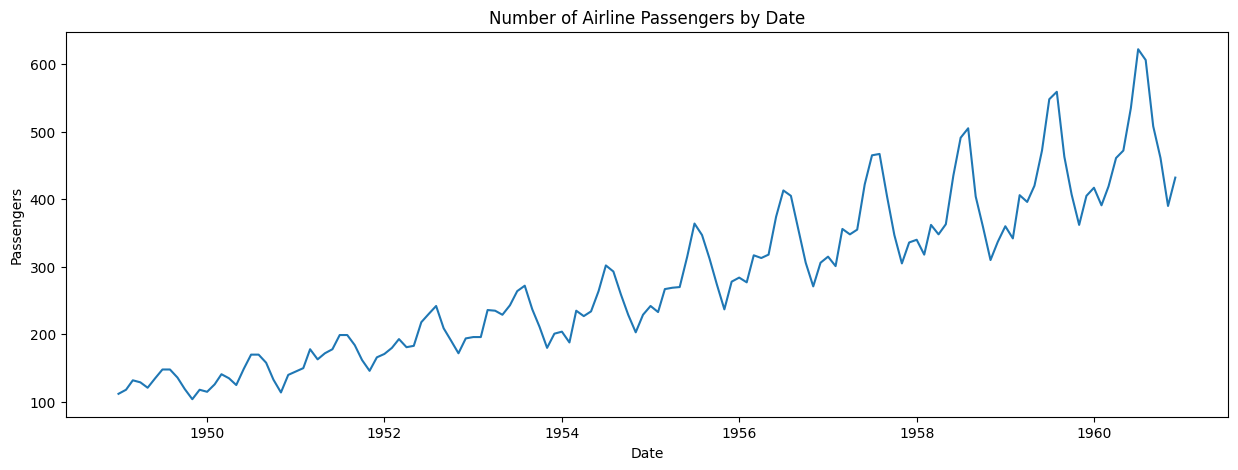

In [3]:
plt.figure(figsize=(15,5))
plt.title('Number of Airline Passengers by Date')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

## Rolling Statistics

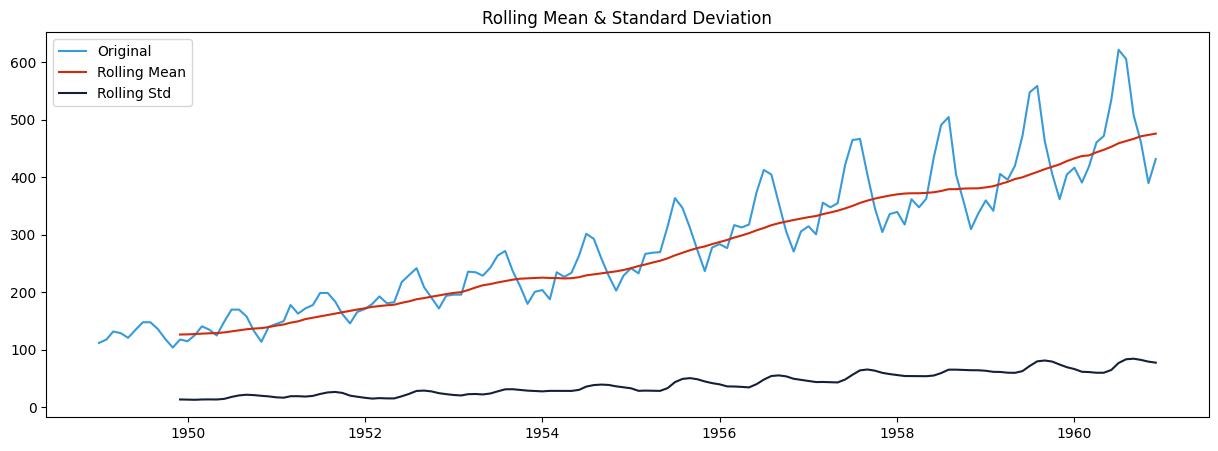

In [4]:
# Determine rolling statistics
#window size 12 denotes 12 months, giving rolling mean at yearly level
df['rolling_avg'] = df['#Passengers'].rolling(window=12).mean()
df['rolling_std'] = df['#Passengers'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15,5))
plt.plot(df['#Passengers'],color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not.\
For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:\
p-value <= significance level (0.01, 0.05, 0.10, etc.)\
If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [6]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
print('p-value is 0.991880, meaning that it is very likely that the data is not stationary')

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
p-value is 0.991880, meaning that it is very likely that the data is not stationary


## ARIMA Model Selection

In [8]:
# Standard ARIMA Model

ARIMA_model = pm.auto_arima(df['#Passengers'],
                                start_p=1, 
                                start_q=1,
                                test='adf', # use adftest to find optimal 'd'
                                max_p=3, max_q=3, # maximum p and q
                                m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                                d=None,# let model determine 'd'
                                seasonal=False, # No Seasonality for standard ARIMA
                                trace=False, #logs 
                                error_action='warn', #shows errors ('ignore' silences these)
                                suppress_warnings=True,
                                stepwise=True)

We can interpret the model as a good fit based on the following conditions.

1. Standardized residual\
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

2. Histogram plus KDE estimate\
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

3. Normal Q-Q\
Most of the data points should lie on the straight line

4. Correlogram (ACF plot)\
95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

### Model Diagnostics

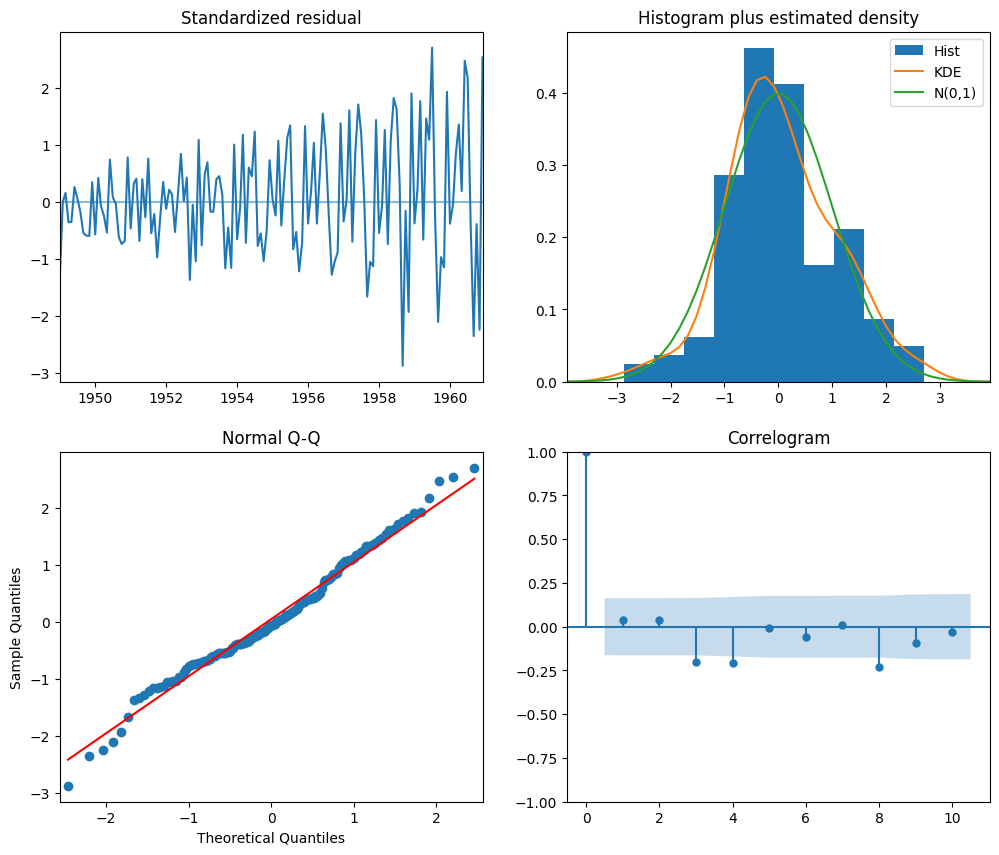

In [10]:
ARIMA_model.plot_diagnostics(figsize=(12,10))
plt.show()

### Forecast

<Figure size 1200x400 with 0 Axes>

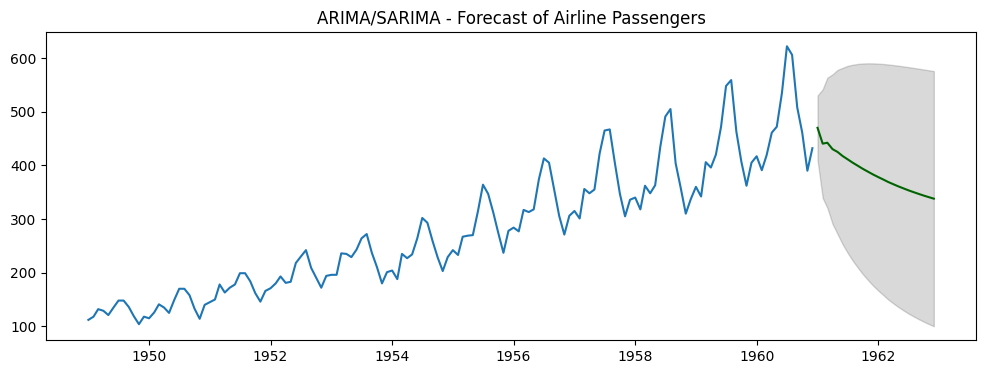

In [13]:
def forecast(ARIMA_model, periods=24):
    # forecast
    fitted, confint = ARIMA_model.predict(n_periods=periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:,0], index=index_of_fc)
    upper_series = pd.Series(confint[:,1], index=index_of_fc)

    # plot
    plt.figure(figsize=(12,4))
    plt.figure(figsize=(12,4))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

## SARIMA Model

In [14]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

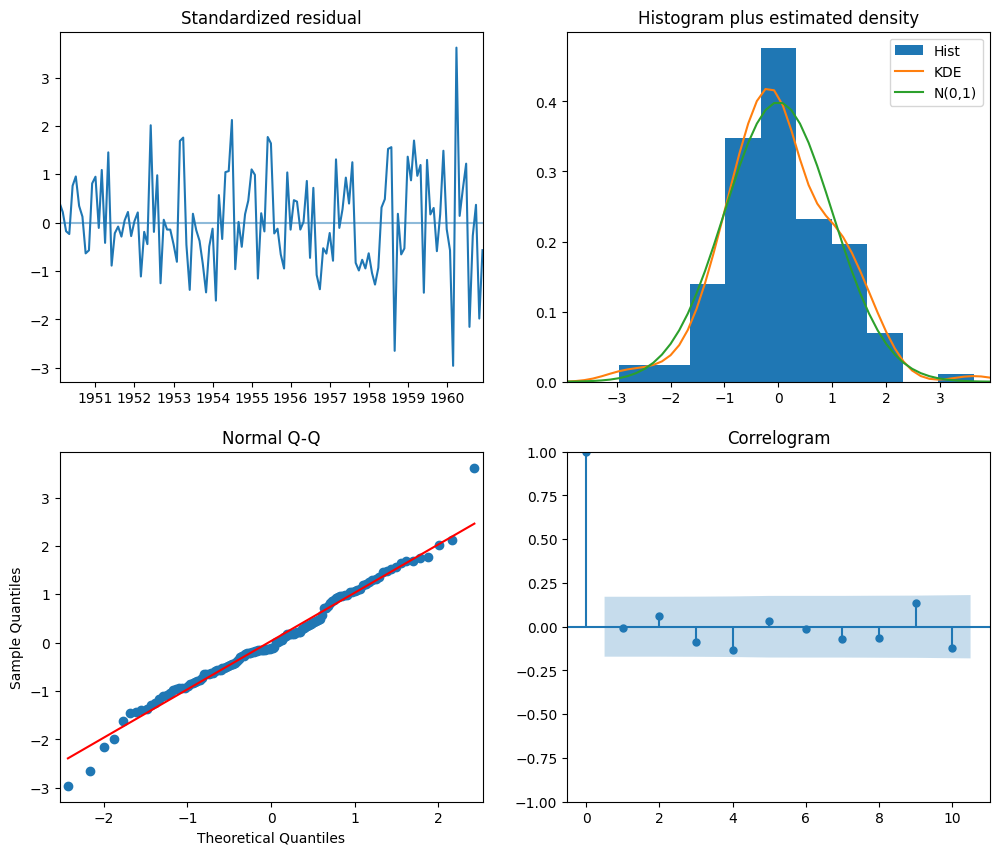

In [17]:
SARIMA_model.plot_diagnostics(figsize=(12,10))
plt.show()

<Figure size 1200x400 with 0 Axes>

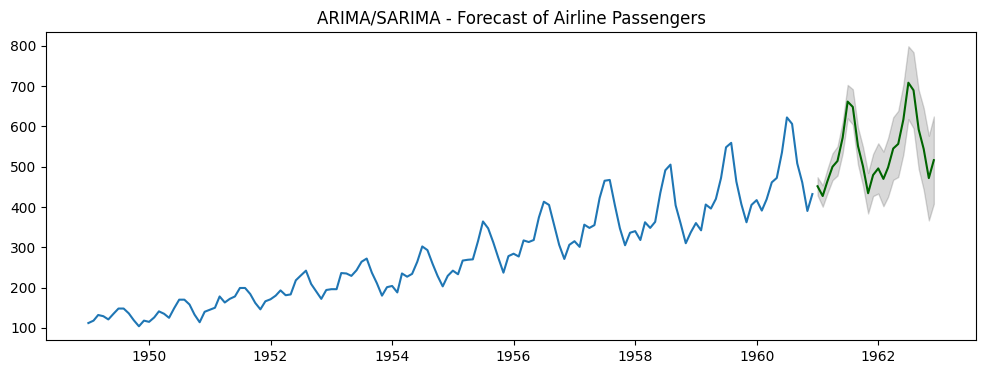

In [18]:
forecast(SARIMA_model)

## SARIMAX

In [25]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], X=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [26]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -507.591
Date:                            Thu, 27 Apr 2023   AIC                           1025.182
Time:                                    09:48:18   BIC                           1039.596
Sample:                                01-01-1949   HQIC                          1031.039
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.8212      2.400      2.426      0.015       1.118      10.525
month_index     0.0055   1136.735   4.82e-06      1.000   -2227.955    2227.966
ar.L1           0.5966      0.084      7.114      0.000       0.432       0.761
ar.L2           0.2128      0.077      2.765      0.006       0.062       0.364
sigma2        127.1720     14.791      8.598      0.000      98.182     156.162
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.50
Prob(Q):                              0.94   Prob(JB):                         0.04
Heteroskedasticity (H):               2.28   Skew:                             0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

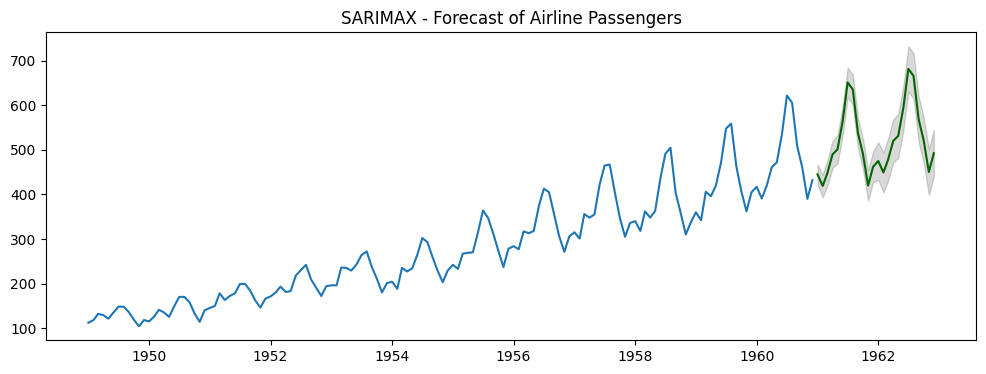

In [28]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    forecast_df = pd.DataFrame({'month_index': pd.date_range(df.index[-1], periods=periods, freq='MS').month},
                               index = pd.date_range(df.index[-1]+pd.DateOffset(months=1), periods=periods, freq='MS'))
    
    fitted, confint = SARIMAX_model.predict(n_periods=periods, return_conf_int=True, X=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1]+pd.DateOffset(months=1), periods=periods, freq='MS')
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)